## Tarea 6: Reconocimiento facial

Mytzi Yael Munguía Cuatlayotl

El reconocimiento facial, en general tiene 3 etapas:

1. Detección de rostros: Detectar los rostros y sus posiciones en una imagen.
2. Alineación de los rostros: Selección de los rostros y su transformación para homogeneizar el tamaño de las imágenes de rostros
3. Extracción de características

Para facilitar este ejercicio, nosotros sólo nos concentraremos en la tarea de extracción de características. Es decir, nuestra red sólo será alimentada con fotos de rostros.

## 2. Segunda parte: Red para el reconocimiento facial

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np

**Se creó una nueva carpeta de imágenes, esta carpeta tiene imágenes mías (32) y otras imágenes de otros rostros, posteriormente realicé un archivo .csv con el nombre de las imágenes y con el atributo: 1 si es mi rostro, 0 si es otro. Al principio había creado un archivo del tipo .txt, pero al querer correr la red encontró muchos errores, así que opte por hacerlo desde un principio en tipo .csv, el cual se separa por comas en lugar de puntos.**

In [5]:
np.set_printoptions(precision=4)
df_myt = pd.read_csv("C:/Users/mytzi/Documents/Redes_Neuronales/Curso-Redes-Neuronales/Reconocimiento_facial/att_mytzi.csv", sep=',', header=None)
path_to_images = "C:/Users/mytzi/Documents/Redes_Neuronales/Curso-Redes-Neuronales/Reconocimiento_facial/imagenes_mytzi/"

**Procesamos el Dataframe, analogamente al caso anterior**

In [6]:
files = tf.data.Dataset.from_tensor_slices(df_myt[0])  # Obtener la primera columna
attributes = tf.data.Dataset.from_tensor_slices(df_myt.iloc[:, 1:].to_numpy())  # Obtener los atributos
data = tf.data.Dataset.zip((files, attributes))  # Combinar los dos anteriores

**Procesamos el conjunto de datos**

<_MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


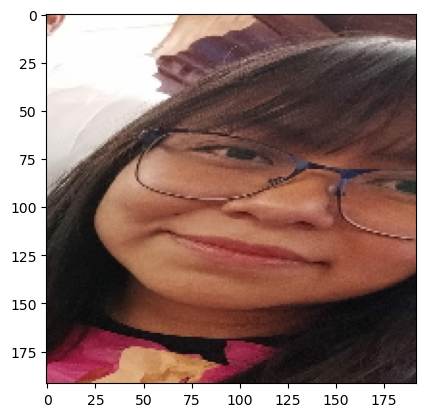

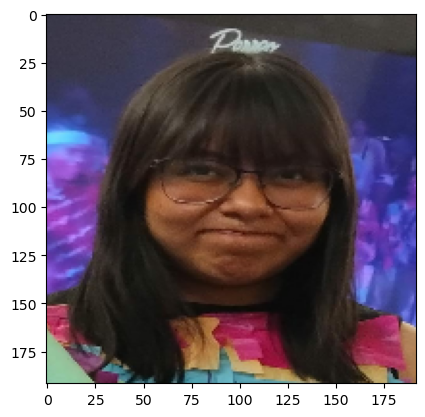

In [9]:
def process_file(file_name, attributes):
    image = tf.io.read_file(path_to_images + file_name)  # Leé el archivo de imagen
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica la imagen
    image = tf.image.resize(image, [192, 192])  # Cambia el tamaño de la imagen
    image /= 255.0  # Normaliza los valores de píxeles al rango [0, 1]
    return image, attributes

# Aplica la función al conjunto de datos
labeled_images = data.map(process_file)

# Imprime información sobre el conjunto de datos procesado
print(labeled_images)

# Visualiza las dos primeras imágenes del conjunto de datos
for image, attri in labeled_images.take(2):
    plt.imshow(image)
    plt.show()

**Dividimos el conjunto de datos**

In [10]:
train_data, test_data = train_test_split(df_myt, test_size=0.2)

**Aumentamos el número de imágenes**

En esta parte me encontré con muchos problemas, pues no reconocía mis imágenes, ya que esperaba etiquetas en las columnas, por lo cual modifiqué el código tal que pudiera tomar las columnas sin necesidad de etiquetas.

In [11]:
# Configurar el generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Crear el generador de imágenes para el conjunto de entrenamiento
train_data_generator = datagen.flow_from_dataframe(
    train_data,
    directory=path_to_images,
    x_col=0,
    y_col=list(train_data.columns[1:]),
    target_size=(192, 192),
    batch_size=64,
    class_mode='raw',  # Utiliza 'raw' para columnas numéricas como salida
)
# Crear el generador de imágenes para el conjunto de prueba
test_data_generator = datagen.flow_from_dataframe(
    test_data,
    directory=path_to_images,
    x_col=0,
    y_col=list(test_data.columns[1:]),
    target_size=(192, 192),
    batch_size=64,
    class_mode='raw',  # Utiliza 'raw' para columnas numéricas como salida
)

Found 12 validated image filenames.
Found 0 validated image filenames.


C:\Users\mytzi\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 52 invalid image filename(s) in x_col="0". These filename(s) will be ignored.
  warnings.warn(
C:\Users\mytzi\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 16 invalid image filename(s) in x_col="0". These filename(s) will be ignored.
  warnings.warn(


In [12]:
# Crear y compilar el modelo binario
pretrained_model = load_model('red_att.h5')
for layer in pretrained_model.layers:
    layer.trainable = False

feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-3].output)

classifier = Sequential([
    layers.Flatten(input_shape=feature_extractor.output_shape[1:]),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

binary_model = Sequential([
    feature_extractor,
    classifier
])

binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo binario con las nuevas imágenes aumentadas
binary_model.fit(train_data_generator, epochs=10, validation_data=test_data_generator)

# Guardar el modelo binario para su uso posterior
binary_model.save('modelo_binario.h5')


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 60.4453 - accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 867ms/step - loss: 28.4380 - accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 61.8791 - accuracy: 0.5833
Epoch 4/10
1/1 [==============================] - 1s 845ms/step - loss: 45.1386 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 768ms/step - loss: 77.7789 - accuracy: 0.4167
Epoch 6/10
1/1 [==============================] - 1s 830ms/step - loss: 51.2308 - accuracy: 0.5833
Epoch 7/10
1/1 [==============================] - 1s 839ms/step - loss: 44.0233 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 1s 855ms/step - loss: 26.4976 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - 1s 899ms/step - loss: 50.8919 - accuracy: 0.4167
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 23.7734 - accuracy: 0.6667


C:\Users\mytzi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
